# **Import Libraries**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')




In [5]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')
print("Drive mounted at /content/drive")

Mounted at /content/drive
Drive mounted at /content/drive


# **PART A: LOADING AND DATA PREPROCESSING**

In [6]:

file_path = '/content/drive/MyDrive/Fundamental of Intelligent Systems/HW 3/train.csv'

df = pd.read_csv(file_path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# Fill missing Age with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing Embarked with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Fill missing Fare if necessary
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)



# **Split dataset**

In [8]:

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Step 5: Train a Decision Tree with**

In [9]:
# Create and train the model
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

# **Step 6: Evaluate the model**

In [10]:

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test set: {accuracy:.4f}")

# Print tree depth and number of leaves
print(f"Tree Depth: {clf.get_depth()}")
print(f"Number of Leaves: {clf.get_n_leaves()}")


Accuracy on Test set: 0.7989
Tree Depth: 4
Number of Leaves: 15


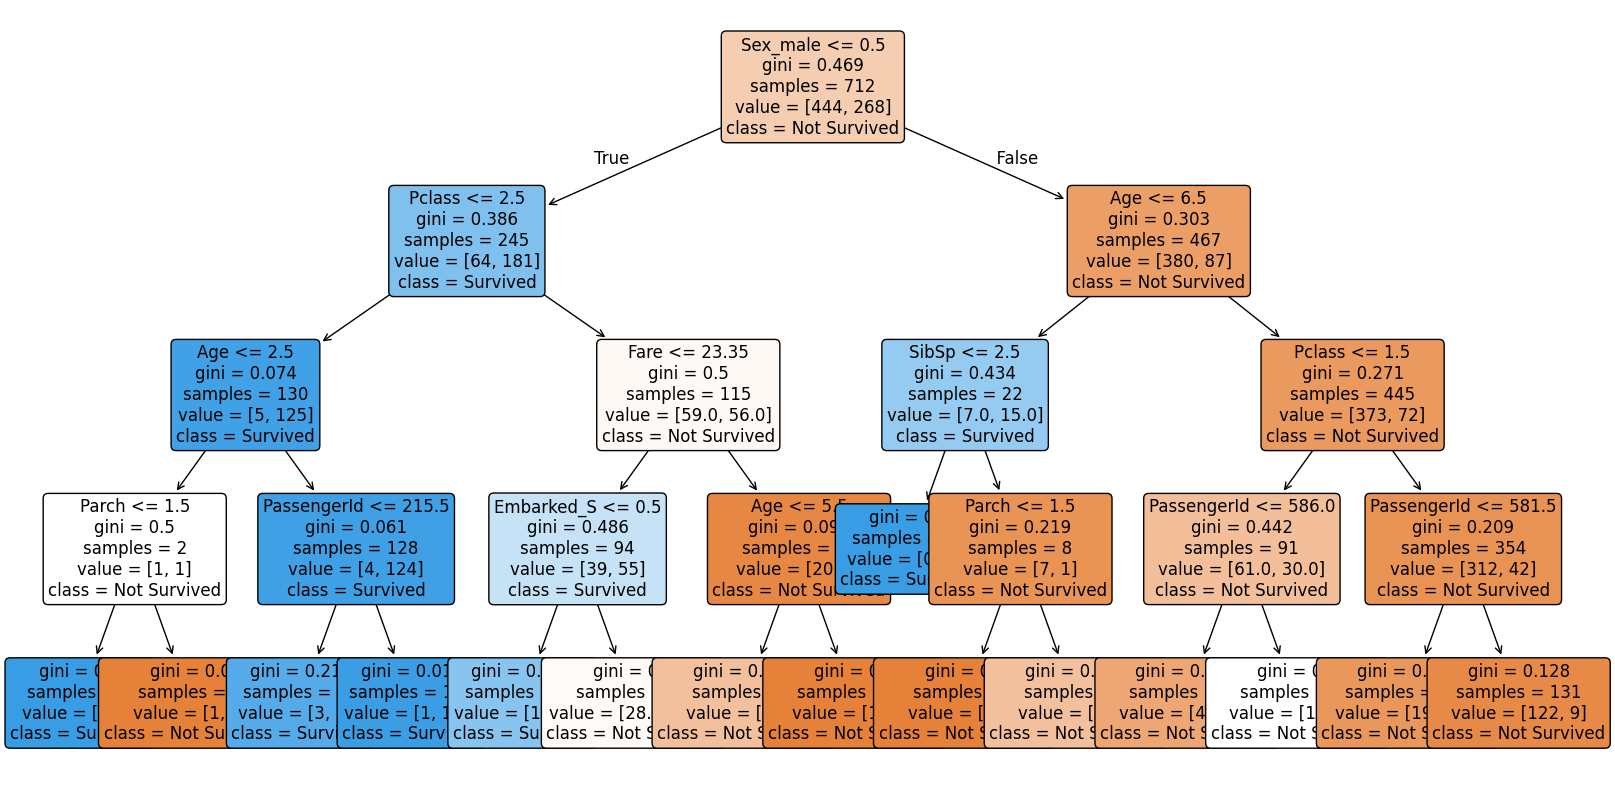

In [11]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True, rounded=True, fontsize=12)
plt.show()


# **Question 6**

**Part (a): Full tree (max_depth=None)**

In [12]:
clf_full = DecisionTreeClassifier(max_depth=None, random_state=42)
clf_full.fit(X_train, y_train)


# Report accuracy
train_acc = clf_full.score(X_train, y_train)
test_acc = clf_full.score(X_test, y_test)
print(f"Full tree train accuracy: {train_acc:.4f}")
print(f"Full tree test accuracy: {test_acc:.4f}")


# Number of nodes and tree depth
print(f"Number of nodes: {clf_full.tree_.node_count}")
print(f"Tree depth: {clf_full.tree_.max_depth}")




Full tree train accuracy: 1.0000
Full tree test accuracy: 0.7207
Number of nodes: 289
Tree depth: 17


**Part (b): Trees with different max_depth values**

In [13]:
for depth in [2, 3, 5, 10, None]:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    print(f"\nTree with max_depth={depth}")
    print(f"Train accuracy: {clf.score(X_train, y_train):.4f}")
    print(f"Test accuracy: {clf.score(X_test, y_test):.4f}")



Tree with max_depth=2
Train accuracy: 0.8034
Test accuracy: 0.7654

Tree with max_depth=3
Train accuracy: 0.8343
Test accuracy: 0.7989

Tree with max_depth=5
Train accuracy: 0.8596
Test accuracy: 0.7989

Tree with max_depth=10
Train accuracy: 0.9508
Test accuracy: 0.7821

Tree with max_depth=None
Train accuracy: 1.0000
Test accuracy: 0.7207


**Part (c): Cost-complexity pruning**

In [14]:

# Ensure clf_full, X_train, and y_train are defined before running this
path = clf_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

# Indent the block below so it runs for each ccp_alpha
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Remove the last tree if it is trivial (one node)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]




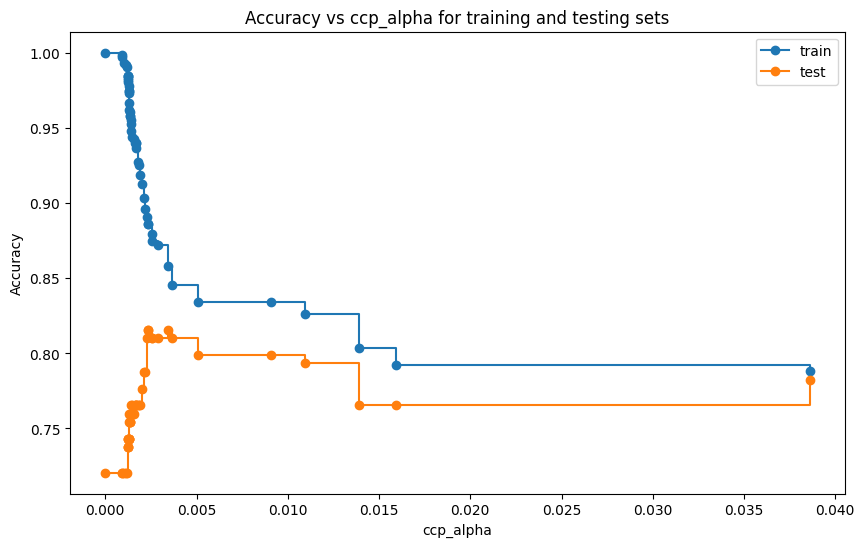

In [15]:
# Evaluate accuracy vs alpha
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ccp_alpha for training and testing sets')
plt.legend()
plt.show()

In [16]:
# Select best alpha (highest test accuracy)
best_alpha = ccp_alphas[test_scores.index(max(test_scores))]
print(f"Best ccp_alpha based on test accuracy: {best_alpha}")


# Train final pruned tree
clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_pruned.fit(X_train, y_train)
print(f"Pruned tree train accuracy: {clf_pruned.score(X_train, y_train):.4f}")
print(f"Pruned tree test accuracy: {clf_pruned.score(X_test, y_test):.4f}")

Best ccp_alpha based on test accuracy: 0.0023408239700374533
Pruned tree train accuracy: 0.8862
Pruned tree test accuracy: 0.8156


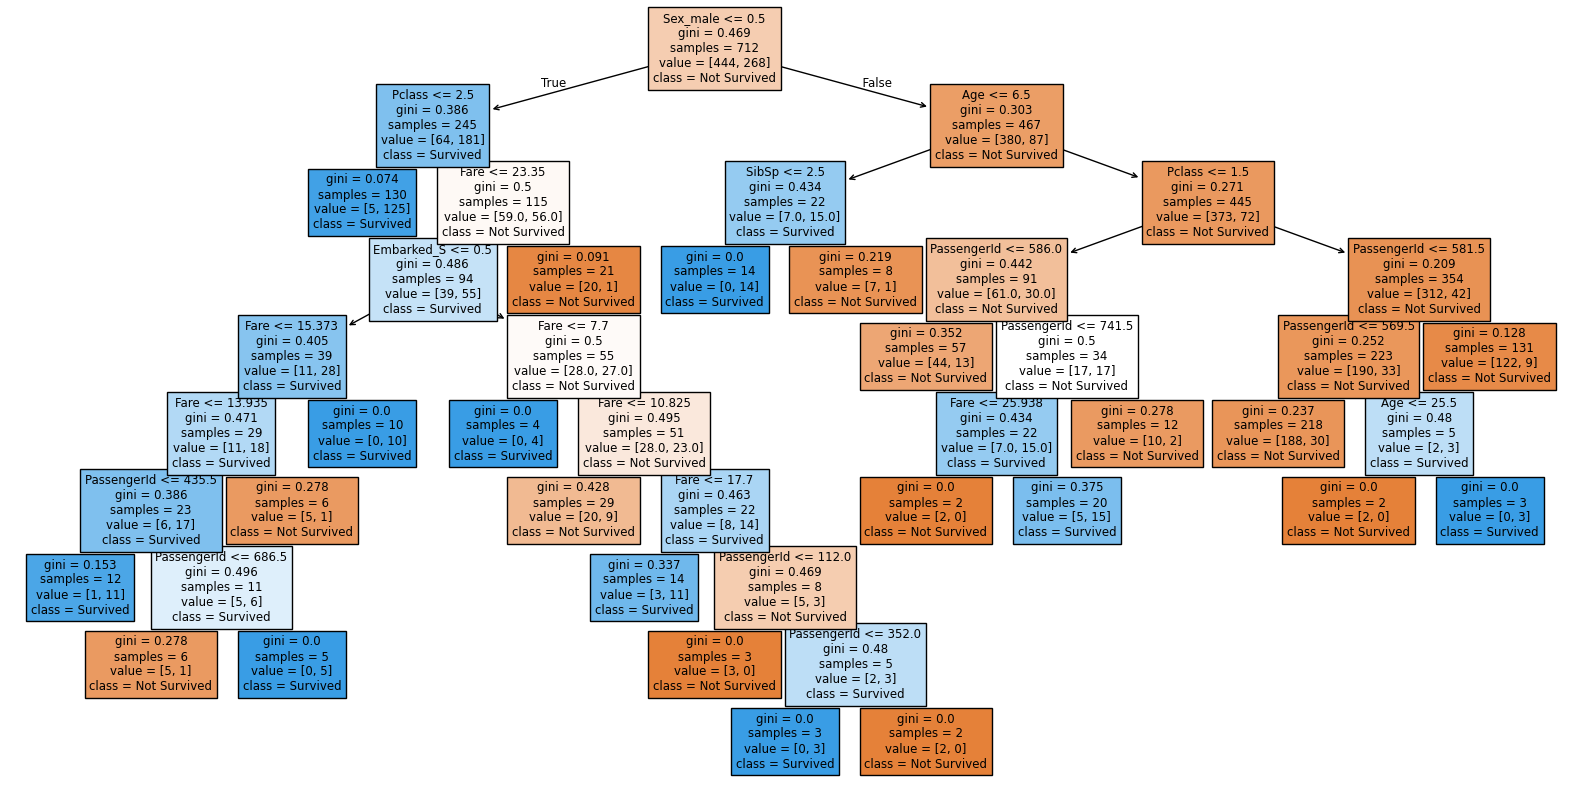

In [17]:
# Plot pruned tree
plt.figure(figsize=(20,10))
plot_tree(clf_pruned, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.show()